# Hello again!

This is Group 9's Jupyter Notebook for data modeling & analysis. Now that we've cleaned up and explored our data, it's time to make use of machine learning models to figure out trends in the data.

Though there might be a bunch of jargon hanging about, we'll try to keep this fun to read through. Enjoy!

---

As always, let's import the things that we need:

In [333]:
%pip install emoji --upgrade
%pip install pyspellchecker

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [334]:
import emoji
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import re
import seaborn as sns
import statsmodels.api as sm
import textwrap

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score, mean_squared_error
from spellchecker import SpellChecker
from textblob import TextBlob

pio.renderers.default = "notebook"  # so that plotly works in an HTML file

# Machine Learning

### Describe the structure and mechanism of the chosen model

The machine learning model we'll use is called __Latent Dirichlet Allocation (LDA)__. You know how a tweet is made up of __tokens__ from data exploration? If we assign a set number of __topics__, then each topic has a bunch of tokens that belong to it. Once we know the tokens related to each topic, we can classify our tweets by these topics.

Before going further, we need the processed dataset from data exploration. This is again hosted in one of Daryll's GitHub repositories, so we'll yoink that into this notebook:

In [335]:
CSV_PATH = "https://raw.githubusercontent.com/daryll-ko/cs132-main/main/analyzer/processed_data_.csv"

In [336]:
df = pd.read_csv(CSV_PATH)

### Train the model using the training data

Before we put in our training data, we'll do a bit more preprocessing.

Let's run some sanity checks across the tweet dates and token lists. The token lists will make sure the data for our LDA model is clean, and we'll use the tweet dates for the regressions later.

In [337]:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

n_samples = 400
n_components = 3
final_dates = []
final_samples = []


def clean_date_unit(s):
    if len(s) == 1:
        return f"0{s}"
    elif len(s) == 4:
        return s[-2:]
    else:
        return s


def valid_month(s):
    return 1 <= int(s) <= 12


bad_date = "00-00-00"


def purify(date):
    matches = re.search(r"^(\d+)/(\d+)/(\d+) .+$", date)
    if matches:
        d, m, y = matches.groups()
        if not valid_month(m):
            d, m = m, d
        m = str((int(m) - 1) // 3 * 3 + 1)
        return f"{clean_date_unit(y)}-{clean_date_unit(m)}"
    else:
        return bad_date


data_samples = df[["Date posted", "Tweet (processed)"]][:n_samples]
for index, row in data_samples.iterrows():
    date, sample = row["Date posted"], row["Tweet (processed)"]
    if isinstance(sample, str):
        tokens = list(
            filter(
                lambda token: token not in ["leni", "robredo", "hahaha"],
                map(lambda token: token[1:-1], sample[1:-1].split(", ")),
            )
        )
        purified_date = purify(date)
        if len(tokens) > 0 and purified_date != bad_date:
            final_dates.append(purified_date)
            final_samples.append(" ".join(tokens))

Now we can make the model do its work! The code below is sourced from [Sir Paul's Colab notebook](https://colab.research.google.com/drive/1Lz4McsTHEp69h0wVSbX8FjSaIIeOXLQA?usp=sharing).

For LDA, we chose __three__ clusters through experimentation. Two clusters wasn't very interesting, while four clusters felt all over the place.

In [338]:
%%capture

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

In [339]:
# Topic modeling via LDA
# Source: https://www.kaggle.com/code/infamouscoder/lda-topic-modeling-features

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


# Custom tokenizer
def tokenizer(text):
    text = emoji.replace_emoji(text, replace="")  # remove emojis
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # remove whitespaces
    tokens = [
        word for word in word_tokenize(text) if len(word) > 3
    ]  # keep only 4+-length words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    filtered_tokens = [
        token for token in lemmatized_tokens if token.lower() not in stop_words
    ]
    # stemmed_tokens = [stemmer.stem(item) for item in tokens]
    return filtered_tokens


# Generate features
tf_vectorizer = TfidfVectorizer(
    tokenizer=tokenizer,
    max_df=0.75,
    max_features=10000,
    use_idf=True,
    norm=None,
    token_pattern=None,
)
tf_vectors = tf_vectorizer.fit_transform(final_samples)

n_topics = 3
lda = decomposition.LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method="online",
    learning_offset=50,
    n_jobs=1,
    random_state=42,
)
W = lda.fit_transform(tf_vectors)
H = lda.components_

num_words = 15
vocab = np.array(tf_vectorizer.get_feature_names_out())
top_words = lambda t: [vocab[i] for i in np.argsort(t)[: -num_words - 1 : -1]]
topic_words = [top_words(t) for t in H]
topics = [" ".join(t) for t in topic_words]
df_topics = pd.DataFrame(topics, columns=["Keywords"])
df_topics["Topic ID"] = range(1, len(topics) + 1)

In [340]:
# Assign topic to each tweet
topicid = ["Topic" + str(i + 1) for i in range(lda.n_components)]
tweetid = ["Tweet" + str(i + 1) for i in range(len(final_samples))]

df_topics_lda = pd.DataFrame(np.round(W, 2), columns=topicid, index=tweetid)
significanttopic = np.argmax(df_topics_lda.values, axis=1) + 1

df_topics_lda["dominant_topic"] = significanttopic
df_topics_lda["breakdown"] = df_topics_lda.apply(
    lambda row: "\n".join(
        [
            f"{col}: {row[col]}"
            for col in sorted(df_topics_lda.columns, key=lambda x: row[x], reverse=True)
            if row[col] > 0 and col != "dominant_topic"
        ]
    ),
    axis=1,
)
df_topics_lda["date"] = pd.to_datetime(np.array(final_dates), format="%y-%m")
df_topics_lda.head(10)

,Topic1,Topic2,Topic3,dominant_topic,breakdown,date
Tweet1,0.99,0.01,0.01,1,Topic1: 0.99\nTopic2: 0.01\nTopic3: 0.01,2022-01-01
Tweet2,0.01,0.00,0.99,3,Topic3: 0.99\nTopic1: 0.01,2022-10-01
Tweet3,0.97,0.01,0.01,1,Topic1: 0.97\nTopic2: 0.01\nTopic3: 0.01,2022-10-01
Tweet4,0.00,0.99,0.00,2,Topic2: 0.99,2022-10-01
Tweet5,0.00,0.99,0.00,2,Topic2: 0.99,2022-10-01
Tweet6,0.99,0.00,0.00,1,Topic1: 0.99,2022-10-01
Tweet7,0.00,0.00,0.99,3,Topic3: 0.99,2022-10-01
Tweet8,0.00,1.00,0.00,2,Topic2: 1.0,2022-10-01
Tweet9,0.00,0.99,0.00,2,Topic2: 0.99,2022-10-01
Tweet10,0.01,0.01,0.99,3,Topic3: 0.99\nTopic1: 0.01\nTopic2: 0.01,2022-04-01


In [341]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_topics_lda.iloc[:, :n_topics])

# Apply K-means clustering
n_topics = 3
kmeans = KMeans(n_clusters=n_topics, n_init=3, random_state=42)
cluster_labels = kmeans.fit_predict(df_topics_lda.iloc[:, :n_topics])

In [342]:
# Create a new dataframe with t-SNE coordinates and cluster labels


def split_text(text, max_length):
    lines = textwrap.wrap(text, width=max_length, break_long_words=False)
    return "<br>".join(lines)


df_topics_cluster = pd.DataFrame(
    {
        "X": tsne_result[:, 0],
        "Y": tsne_result[:, 1],
        "Tweet": final_samples,
        "Cluster": df_topics_lda.reset_index()["dominant_topic"].astype(
            str
        ),  # topics via LDA
        # 'Cluster': cluster_labels},                                         # clusters via K-means
        "Breakdown": df_topics_lda.reset_index()["breakdown"],
    }
)

df_topics_cluster["Tweet"] = df_topics_cluster["Tweet"].apply(
    lambda x: split_text(x, 40)
)
df_topics_cluster["Breakdown"] = df_topics_cluster["Breakdown"].str.replace(
    "\n", "<br>"
)

df_topics_cluster.head(10)

,X,Y,Tweet,Cluster,Breakdown
0,-230.556030,-202.595703,wala alam foreign policy alam presidente<br>au...,1,Topic1: 0.99<br>Topic2: 0.01<br>Topic3: 0.01
1,140.802063,78.263054,walang ambag maritime industry years vp<br>nev...,3,Topic3: 0.99<br>Topic1: 0.01
2,-325.934143,-29.314631,inggit walang ambag moro chaka,1,Topic1: 0.97<br>Topic2: 0.01<br>Topic3: 0.01
3,-17.466452,268.300690,wala kasing ibang topic alam walang alam<br>ph...,2,Topic2: 0.99
4,-17.466452,268.300690,vovo matagal walang galaw unilever<br>ngayon g...,2,Topic2: 0.99
5,-41.246140,-274.737518,engot buhay nalang ngayon flops lutang<br>wala...,1,Topic1: 0.99
6,172.522018,125.494598,ayan nasimulan aminin nalang kakampwets<br>inf...,3,Topic3: 0.99
7,20.545570,343.701538,bwahaha hahahaha parallel universe<br>gobyerno...,2,Topic2: 1.0
8,-17.466452,268.300690,huwag ibase respeto credentials tao<br>kahit s...,2,Topic2: 0.99
9,196.098480,20.883001,nasa posisyon habang pandemya nagawan<br>paraa...,3,Topic3: 0.99<br>Topic1: 0.01<br>Topic2: 0.01


In [343]:
# Plot tweets as colored points
df_topics_cluster.sort_values(
    "Cluster", key=lambda x: pd.to_numeric(x, errors="coerce"), inplace=True
)

fig = px.scatter(
    df_topics_cluster,
    x="X",
    y="Y",
    color="Cluster",
    title="Topic Clustering using LDA and t-SNE",
    hover_name="Tweet",
    hover_data={
        "X": False,
        "Y": False,
        "Cluster": False,
        "Tweet": False,
        "Breakdown": True,
    },
)

for i, keyword in enumerate(df_topics["Keywords"]):
    fig.add_annotation(
        x=0,
        y=-0.2 * (i / 5) - 0.08,
        text="Topic %d: %s" % (i + 1, keyword.replace(" ", ", ")),
        showarrow=False,
        xref="paper",
        yref="paper",
        align="left",
        font=dict(color=fig.data[i].marker["color"]),
    )

fig.update_layout(
    height=710,
    xaxis_title="",
    yaxis_title="",
    margin=dict(b=200),
    paper_bgcolor="white",
    title=dict(font=dict(color="black")),
    legend=dict(title="Topic", font=dict(color="black")),
)
fig.show()

### Evaluate the model's performance using the appropriate evaluation metrics

Each cluster can be associated with a corresponding theme:

- __Red__: This cluster may be related to __marginalization__. Notice that "natin", "namin", "kayong", and "kang" are there, indicating a sense of othering being established. There is also the word "atty", which may be zooming in the fact that Leni is also a lawyer.
- __Blue__: This cluster may be related to __competence__. We see words like "lutang", "fake", and "alam", which we may attribute to Leni's capabilities (and thus, competence) during her term as VP.
- __Green__: This cluster may be related to __election fraud__. Words like "election", "vote", and "smartmatic" appear, which we could relate to the 2016 elections.

### Evaluation results

Though we see underlying themes, further analysis through __more thorough preprocessing__ or __incorporating more data and clusters__ may provide even more insights and stronger results.

# Statistical Hypothesis Test

### Perform the appropriate statistical test based on the hypothesis.

Our hypothesis is that some clusters/themes have increasing trends. To verify this, we'll be doing multiple __linear regressions__. These regressions will look at the relationship between each cluster and time.

### Identify and validate the assumptions of the chosen statistical model. Discuss any violations of assumptions and their potential impact on the results.

According to [this site](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html), the assumptions associated with a linear regression model are:

- Linearity: The relationship between X and the mean of Y is linear.
	- Our tweets alongside with other groups' tweets were mostly collected uniformly across the 6 years, so there is unlikely to be exponential increases over time.
- Homoscedasticity: The variance of residual is the same for any value of X.
	- Though we did not check this directly, this is something to can look into when we see the regression graphs.
- Independence: Observations are independent of each other.
	- From our dataset, we know that different tweets are likely from different users. We can thus say that our tweets are independent.
- Normality: For any fixed value of X, Y is normally distributed.
	- Incorporating other group's data made our sample size not too big and not too small.

### Clearly report the test statistics, p-values, and any effect size measures.

Before making the actual regressions, let's look at the general trends when we group tweets in intervals of three months:

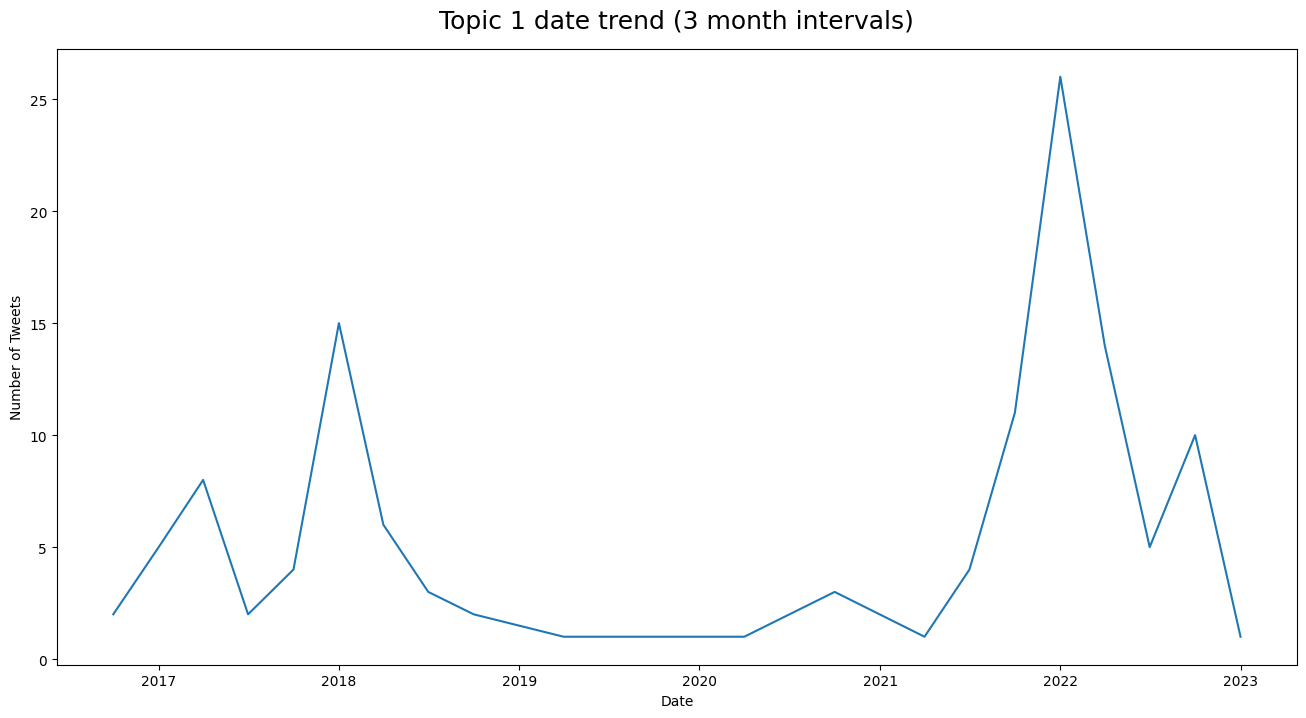

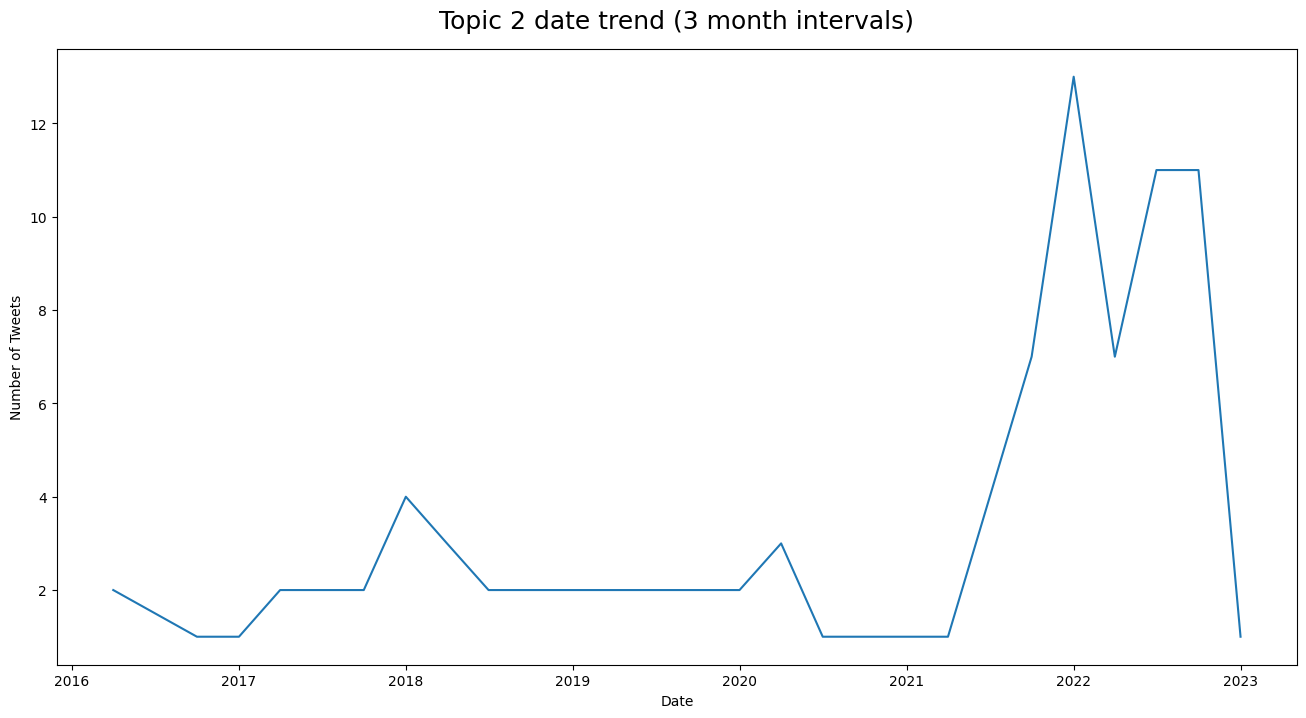

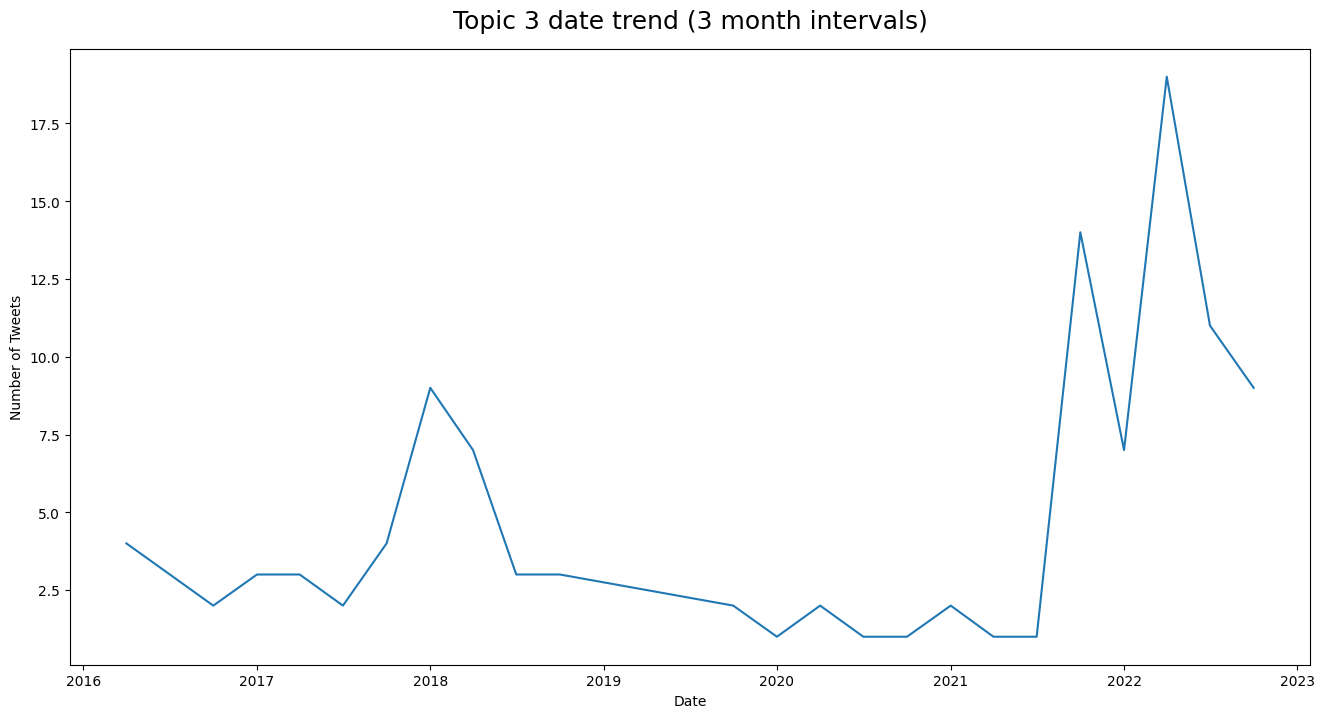

In [344]:
for topic in range(1, 3 + 1):
    topic_df = df_topics_lda[df_topics_lda["dominant_topic"] == topic]

    date_dict = {}
    for index, row in topic_df.iterrows():
        if row["date"] in date_dict:
            date_dict[row["date"]] += 1
        else:
            date_dict[row["date"]] = 1

    date_df_dict = {"date": date_dict.keys(), "count": date_dict.values()}
    date_df = pd.DataFrame.from_dict(date_df_dict)

    plt.figure(figsize=(16, 8))
    sns.lineplot(data=date_df, x="date", y="count")

    plt.ticklabel_format(style="plain", axis="y")
    plt.xlabel("Date")
    plt.ylabel("Number of Tweets")
    plt.title(f"Topic {topic} date trend (3 month intervals)", size=18, y=1.02)

    plt.show()

Cool! Now for the actual regressions. The code above and below was sourced from [Sir Paul's Colab notebook](https://colab.research.google.com/drive/1Lz4McsTHEp69h0wVSbX8FjSaIIeOXLQA?usp=sharing). The results are shown alongside the regression graphs.

In [345]:
## Perform regression modeling

colors_text = ["Red", "Blue", "Green"]
colors_hex = ["#ee563b", "#656ffa", "#00cd96"]

for topic in range(1, 3 + 1):
    topic_df = df_topics_lda[df_topics_lda["dominant_topic"] == topic]

    date_dict = {}
    for index, row in topic_df.iterrows():
        if row["date"] in date_dict:
            date_dict[row["date"]] += 1
        else:
            date_dict[row["date"]] = 1

    date_df_dict = {"date": date_dict.keys(), "count": date_dict.values()}
    date_df = pd.DataFrame.from_dict(date_df_dict)

    # Convert datetime to int
    x = date_df["date"].astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
    x = x.values.reshape(-1, 1)

    y = date_df["count"]

    # --------------------------------------------------------------
    # Linear regression model
    # --------------------------------------------------------------
    # Stastical approach
    x_lms = sm.add_constant(x)
    linear_model_stat = sm.OLS(y, x_lms)
    lms_results = linear_model_stat.fit()
    p_values = lms_results.pvalues[1:]

    # Machine learning approach (no p-values)
    linear_model = LinearRegression()
    linear_model.fit(x_lms, y)
    y_linear_pred = linear_model.predict(x_lms)

    # Calculate R2 and RMSE for linear regression model
    linear_r2 = r2_score(y, y_linear_pred)
    linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

    print("Model Evaluation")
    print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
    for i, p_value in enumerate(p_values.index):
        print(f"P({p_value}): {p_values[i]}")

    if any(p_values <= 0.03):
        print(
            "There is a significant relationship between the predictor and the response\n"
        )
    else:
        print(
            "There is no significant relationship between the predictor and the response\n"
        )

    # Plot the model
    import plotly.graph_objects as go

    xtt = date_df["date"].dt.strftime("%y-%m")
    scatter_actual = go.Scatter(
        x=xtt,
        y=y,
        mode="markers",
        name="Actual",
        marker=dict(color="blue", opacity=0.3),
    )

    line_regression = go.Scatter(
        x=xtt,
        y=y_linear_pred,
        mode="lines",
        name="LR",
        line=dict(color=colors_hex[topic - 1], dash="dash"),
    )

    data = [scatter_actual, line_regression]

    layout = go.Layout(
        xaxis=dict(title="Date"),
        yaxis=dict(title="Tweet Count"),
        title=f"Linear Regression Model for the {colors_text[topic - 1]} Cluster",
        showlegend=True,
        height=600,
    )

    fig = go.Figure(data=data, layout=layout)
    fig.update_xaxes(tickfont_size=20)
    fig.update_yaxes(title={"font": {"size": 20}}, tickfont_size=20)
    fig.show()

Model Evaluation

Linear Regression: RMSE=5.89, R2=0.06
P(x1): 0.25495815422448237
There is no significant relationship between the predictor and the response



Model Evaluation

Linear Regression: RMSE=3.00, R2=0.32
P(x1): 0.0070335316621953975
There is a significant relationship between the predictor and the response



Model Evaluation

Linear Regression: RMSE=4.25, R2=0.16
P(x1): 0.05845134268370579
There is no significant relationship between the predictor and the response



### Interpret the results and provide a conclusion based on the hypothesis test.

We see that the blue cluster (competence) has a significant increasing trend based on our threshold of $0.03$. The other clusters do not have statistically significant trends.

This __validates__ our alternative hypothesis: some clusters indeed have increasing trends.

# Goodbye!

That wraps up the data modeling & analysis of the Group 9 dataset. We hope you enjoyed seeing the process evolve, and feel free to apply some of the ideas here in your own future works.

That's all from `<Team Name>` for now. Until next time! 👋